# Modelowanie binarne regresji logistycznej w Pythonie - projekt.

Opracował: Kwiek Kamil

### Objaśnienie zbioru danych.

W tym przykładzie użyjemy zestawu danych dotyczących cukrzycy u pacjentów, otrzymanego z Repozytorium baz danych uczenia maszynowego UCI (Newman et al. 1998). Ten zestaw danych pochodzi pierwotnie z Narodowego Instytutu Chorób Cukrzycy i Układu Pokarmowego oraz Nerek.

#### Zmienne niezależne:


**ciąża**: liczba ciąż,

**glukoza**: stężenie glukozy we krwi (test tolerancji glukozy),

**ciśnienie**: ciśnienie krwi skurczowe (mm Hg),

**trójglicerydy**: grubość fałdu skórnego tricepsa (mm),

**insulin**: poziom insuliny w surowicy krwi po 2 godzinach od spożycia glukozy (mu U/ml),

**BMI**: wskaźnik masy ciała (waga w kg / (wzrost w m)\²),

**funkcja rodowodu cukrzycowego**: wartość funkcji rodowodu cukrzycowego,

**wiek**: wiek (lata)

#### Zmienna zależna:


**cukrzyca**: przypadek cukrzycy (pozytywny/negatywny),

### Cele modelowania

* Testowanie siły predykcyjnej wytrenowanego modelu na zestawie testowym danych przy użyciu różnych metryk oceny modelu.
* Diagnostyczne przewidywanie, czy pacjent ma cukrzycę, na podstawie określonych pomiarów diagnostycznych zawartych w zestawie danych.

### Importowanie potrzebnych bibliotek.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Importowanie zbioru danych zawartym w pliku csv.

In [2]:
data = pd.read_csv('C:/Users/PC/OneDrive/Pulpit/indian_pima2.csv', na_values = ['NA']) #Zamienienie wszystkich 'NA' na null

### Podgląd danych

In [3]:
data.head()

,Unnamed: 0,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
0,1,6,148.0,72.0,35.0,NaN,33.6,0.627,50,pos
1,2,1,85.0,66.0,29.0,NaN,26.6,0.351,31,neg
2,3,8,183.0,64.0,NaN,NaN,23.3,0.672,32,pos
3,4,1,89.0,66.0,23.0,94.0,28.1,0.167,21,neg
4,5,0,137.0,40.0,35.0,168.0,43.1,2.288,33,pos


In [4]:
print(data)

     Unnamed: 0  pregnant  glucose  pressure  triceps  insulin  mass  \
0             1         6    148.0      72.0     35.0      NaN  33.6   
1             2         1     85.0      66.0     29.0      NaN  26.6   
2             3         8    183.0      64.0      NaN      NaN  23.3   
3             4         1     89.0      66.0     23.0     94.0  28.1   
4             5         0    137.0      40.0     35.0    168.0  43.1   
..          ...       ...      ...       ...      ...      ...   ...   
763         764        10    101.0      76.0     48.0    180.0  32.9   
764         765         2    122.0      70.0     27.0      NaN  36.8   
765         766         5    121.0      72.0     23.0    112.0  26.2   
766         767         1    126.0      60.0      NaN      NaN  30.1   
767         768         1     93.0      70.0     31.0      NaN  30.4   

     pedigree  age diabetes  
0       0.627   50      pos  
1       0.351   31      neg  
2       0.672   32      pos  
3       0.167  

Zestaw danych dotyczący cukrzycy zawiera `768 obserwacji` i `10 zmiennych`. Pierwsze 8 zmiennych są typu numerycznego, a zmienna zależna jest typu kategorycznego. Zauważalne jest również, że wiele zmiennych zawiera wartości null. Naszym kolejnym zadaniem jest modyfikacja danych tak, aby były kompatybilne z algorytmem modelowania.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  768 non-null    int64  
 1   pregnant    768 non-null    int64  
 2   glucose     763 non-null    float64
 3   pressure    733 non-null    float64
 4   triceps     541 non-null    float64
 5   insulin     394 non-null    float64
 6   mass        757 non-null    float64
 7   pedigree    768 non-null    float64
 8   age         768 non-null    int64  
 9   diabetes    768 non-null    object 
dtypes: float64(6), int64(3), object(1)
memory usage: 60.1+ KB


In [6]:
data.describe()

,Unnamed: 0,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age
count,768.000000,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000
mean,384.500000,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885
std,221.846794,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232
min,1.000000,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,192.750000,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000
50%,384.500000,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000
75%,576.250000,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000
max,768.000000,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


### Czyszczenie danych

In [7]:
# Sprawdzenie, czy zbiór danych zawiera wartości null
print(data.isnull().values.any())

True


In [8]:
# Liczba wartości null w każdej kolumnie
print(data.isnull().sum())

Unnamed: 0      0
pregnant        0
glucose         5
pressure       35
triceps       227
insulin       374
mass           11
pedigree        0
age             0
diabetes        0
dtype: int64


In [9]:
# Usunięcie wierszy zawierających wartości null
data = data.dropna()

# Usunięcie kolumn zawierających wartości null
data = data.dropna(axis=1)

In [10]:
# Liczba wartości null w każdej kolumnie
print(data.isnull().sum())

Unnamed: 0    0
pregnant      0
glucose       0
pressure      0
triceps       0
insulin       0
mass          0
pedigree      0
age           0
diabetes      0
dtype: int64


Udało się usunąć wszystkiw wartości `null` z naszego zbioru danych.

In [11]:
print(data)

     Unnamed: 0  pregnant  glucose  pressure  triceps  insulin  mass  \
3             4         1     89.0      66.0     23.0     94.0  28.1   
4             5         0    137.0      40.0     35.0    168.0  43.1   
6             7         3     78.0      50.0     32.0     88.0  31.0   
8             9         2    197.0      70.0     45.0    543.0  30.5   
13           14         1    189.0      60.0     23.0    846.0  30.1   
..          ...       ...      ...       ...      ...      ...   ...   
753         754         0    181.0      88.0     44.0    510.0  43.3   
755         756         1    128.0      88.0     39.0    110.0  36.5   
760         761         2     88.0      58.0     26.0     16.0  28.4   
763         764        10    101.0      76.0     48.0    180.0  32.9   
765         766         5    121.0      72.0     23.0    112.0  26.2   

     pedigree  age diabetes  
3       0.167   21      neg  
4       2.288   33      pos  
6       0.248   26      pos  
8       0.158  

Ostateczne dane zawierają `392 obserwacje` i `10 kolumn`. Zmienne niezależne są typu numerycznego, a zależna binarna zmienna wyjściowa jest typu kategorycznego (neg/pos).

### Sprawdzenie poziomu referencyjnego

Dla lepszej interpretacji (później przy tworzeniu krzywej ROC) musimy ustawić poziom referencyjny naszej zmiennej zależnej `diabetes` na pozytywny (pos) przy użyciu funkcji `replace()`.

Sprawdzamy poziom referencyjny naszej zmiennej o

In [12]:
pierwszy_poziom = data['diabetes'].value_counts().index[0]

print("Pierwszy poziom zmiennej zależnej to:", pierwszy_poziom)

Pierwszy poziom zmiennej zależnej to: neg


In [13]:
data['diabetes'] = data['diabetes'].replace({'pos': 'neg', 'neg': 'pos'})

In [14]:
pierwszy_poziom = data['diabetes'].value_counts().index[0]

print("Pierwszy poziom zmiennej zależnej to:", pierwszy_poziom)

Pierwszy poziom zmiennej zależnej to: pos


### Podział na zbiór treningowy i testowy

Podział całego zbioru danych na zbiór treningowy i testowy to zazwyczaj `75% zbioru treningowego` i `25% zbioru testowego` (reguła ogólna). `3/4` danych treningowych jest używane do treningu modelu, a pozostała `1/4` służy do sprawdzenia, jak model generalizuje na nowych danych testowych.

In [20]:
X = data.drop('diabetes', axis=1)
y = data['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
# wyświetlenie wymiarów zbiorów
print('Rozmiary zbiorów:')
print(f'Zbiór treningowy: {X_train.shape}, diabetes: {y_train.shape}')
print(f'Zbiór testowy: {X_test.shape}, diabetes: {y_test.shape}')

Rozmiary zbiorów:
Zbiór treningowy: (294, 9), diabetes: (294,)
Zbiór testowy: (98, 9), diabetes: (98,)


Zbiór treningowy zawiera `294 obserwacji`, natomiast zbiór testowy zawiera `98 obserwacji`.

### Dopasowanie regresji logistycznej

In [32]:
# Dopasowanie modelu regresji logistycznej
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Predykcja modelu

In [28]:
#Generowanie predykcji dla danych testowych
y_pred = logistic_model.predict(X_test)

In [33]:
#Wyświetlenie pięciu pierwszych wierszy predykcji klas
y_pred[1:5,]

array(['pos', 'pos', 'neg', 'neg'], dtype=object)

In [36]:
#Generowanie prawdopodobieństw klas dla danych testowych
y_proba = logistic_model.predict_proba(X_test)

In [38]:
#Wyświetlenie pięciu pierwszych wierszy predykcji prawdopodobieństw klas dla danych testowych (odpowiednio pos i neg)
y_proba[1:5,]

array([[0.29182507, 0.70817493],
       [0.02711186, 0.97288814],
       [0.89776553, 0.10223447],
       [0.82303632, 0.17696368]])

### Przygotowanie danych końcowych do oceny modelu

Następnym krokiem jest przygotowanie ramki danych, która zawiera kolumnę `diabetes` z oryginalnego zestawu testowego, `przewidywaną klasę` i `prawdopodobieństwa przewidywanej klasy`.

In [44]:
# Tworzenie ramki danych
result_df = pd.DataFrame()
result_df['diabetes'] = y_test
result_df['przewidywana klasa'] = y_pred
result_df['pred_pos'] = y_proba[:, 0]
result_df['pred_neg'] = y_proba[:, 1]

In [45]:
result_df.head()

,diabetes,przewidywana klasa,pred_pos,pred_neg
161,pos,pos,0.295558,0.704442
538,pos,pos,0.291825,0.708175
482,pos,pos,0.027112,0.972888
120,neg,neg,0.897766,0.102234
753,neg,neg,0.823036,0.176964


### Ocena modelu

In [46]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Dokładność modelu: {:.2f}%".format(accuracy*100))

Dokładność modelu: 72.45%


In [47]:
from sklearn.metrics import confusion_matrix
# Tworzenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[16 16]
 [11 55]]


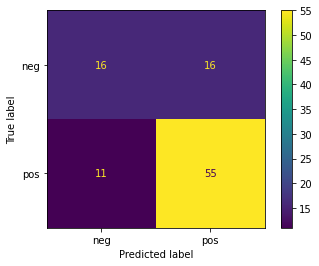

In [48]:
from sklearn.metrics import plot_confusion_matrix

# Wyświetlanie macierzy pomyłek
plot_confusion_matrix(logistic_model, X_test, y_test)
plt.show()

### ROC - AUC

`Krzywa ROC` to narzędzie służące do oceny wydajności modelu klasyfikacji binarnej. Przedstawia zależność między czułością (true positive rate- TPR) a specyficznością (ang. true negative rate - TNR) w różnych punktach odcięcia (progu) dla klasyfikatora. Krzywą ROC można wygenerować za pomocą funkcji `roc_auc_score()`, w której trzeba podać kolumnę prawdy (cukrzyca) oraz przewidywane prawdopodobieństwa dla klasy pozytywnej (y_prob).

In [87]:
from sklearn.metrics import roc_auc_score

# Obliczanie ROC AUC dla zbioru testowego
y_prob = logistic_model.predict_proba(X_test)[:, 1] # wybieramy kolumnę dla klasy pozytywnej
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC wynosi: {:.2f}".format(roc_auc))

ROC AUC wynosi: 0.81


### Krzywa ROC

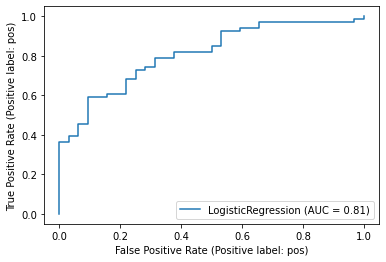

In [86]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(logistic_model, X_test, y_test)
plt.show()

### Podsumowanie

Nasz model uzyskał wynik `ROC-AUC` wynoszący `0.81`, co wskazuje na `dobrze działający model, który potrafi odróżnić pacjentów z cukrzycą od tych bez niej`.